In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

import os
data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD']

for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'H1_'+i+'_2015.csv')
    print(data_path)
    df = pd.read_csv(data_path, index_col=0)
    
    # Convert Unix timestamps to datetime format
    df['Time'] = pd.to_datetime(df['time'], unit='s')
    
    if 'volume' not in df.columns:
        df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
    else:
        df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

#     data = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date")
    break

data = df
data['Date'] = data['Time']

D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\H1_EURUSD_2015.csv


In [12]:
data["Close"] = df["Close"].rolling(window=9).mean()

In [14]:
data

,time,Open,High,Low,Close,Volume,spread,real_volume,Time,Date
0,1420048800,1.20997,1.21089,1.20966,1.20999,3237,17,0,2014-12-31 18:00:00,2014-12-31 18:00:00
1,1420185600,1.20481,1.20569,1.20479,1.20538,1254,17,0,2015-01-02 08:00:00,2015-01-02 08:00:00
2,1420189200,1.20537,1.20574,1.20341,1.20553,3394,17,0,2015-01-02 09:00:00,2015-01-02 09:00:00
3,1420192800,1.20556,1.20689,1.20442,1.20469,4590,17,0,2015-01-02 10:00:00,2015-01-02 10:00:00
4,1420196400,1.20468,1.20599,1.20380,1.20573,4335,17,0,2015-01-02 11:00:00,2015-01-02 11:00:00
...,...,...,...,...,...,...,...,...,...,...
61933,1734688800,1.03816,1.03974,1.03770,1.03913,5104,17,0,2024-12-20 10:00:00,2024-12-20 10:00:00
61934,1734692400,1.03913,1.03915,1.03749,1.03817,4389,17,0,2024-12-20 11:00:00,2024-12-20 11:00:00
61935,1734696000,1.03818,1.03921,1.03803,1.03908,3521,17,0,2024-12-20 12:00:00,2024-12-20 12:00:00
61936,1734699600,1.03908,1.03964,1.03785,1.03906,3663,17,0,2024-12-20 13:00:00,2024-12-20 13:00:00


In [17]:
data = df.sort_index()

/home/iftekhar/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Best Combination: Short Window = 15, Long Window = 40
Best Balance Growth: 1.11


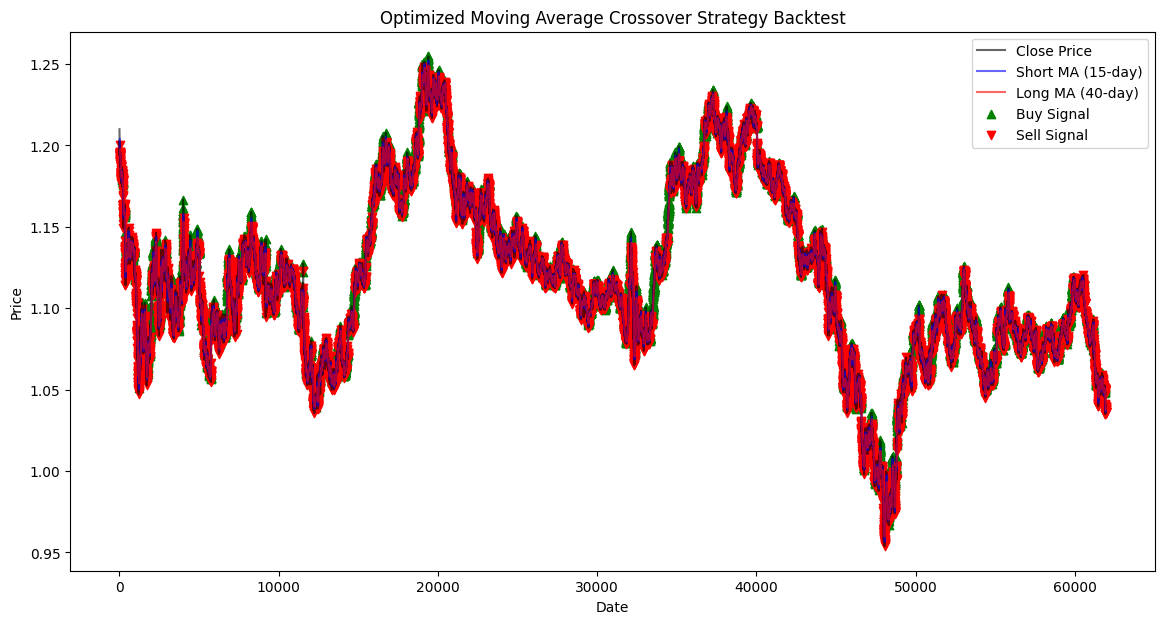

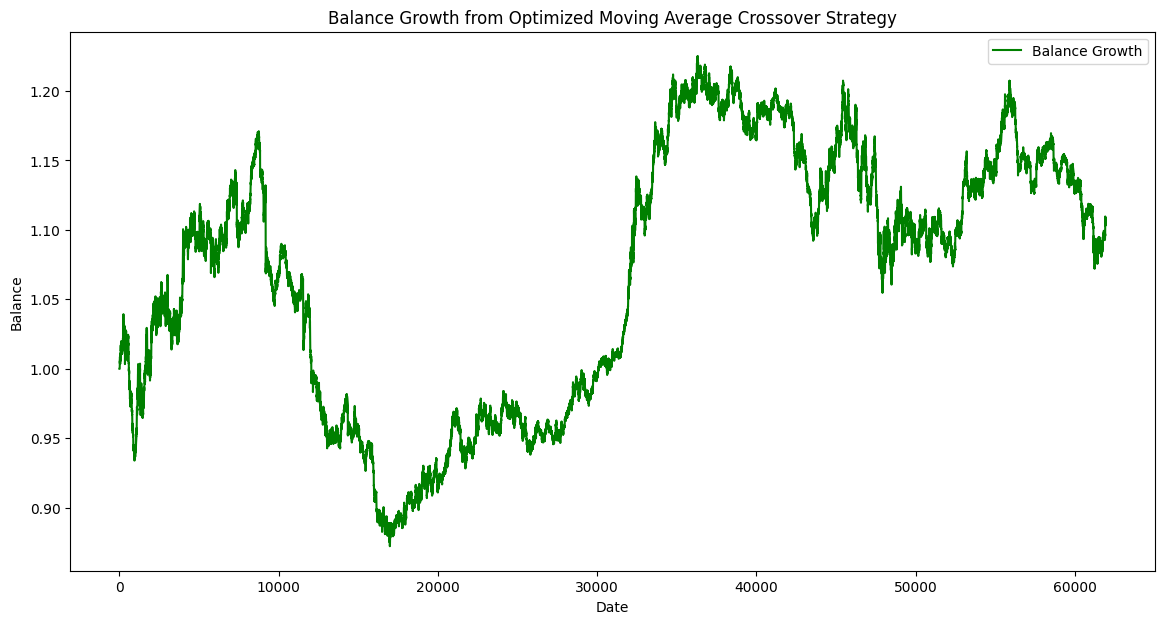

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Ensure the dataset has a 'Close' column
if "Close" not in data.columns:
    raise ValueError("Dataset must have a 'Close' column.")

# Define the moving average crossover strategy with parameters
def moving_average_crossover(data, short_window, long_window):
    """
    Backtest a Moving Average Crossover strategy.
    Buy when the short-term MA crosses above the long-term MA.
    Sell when the short-term MA crosses below the long-term MA.
    """
    # Calculate the short and long moving averages
    data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
    data["Long_MA"] = data["Close"].rolling(window=long_window).mean()

    # Create the signal column: 1 for Buy, -1 for Sell, 0 for Hold
    data["Signal"] = 0
    data["Signal"][short_window:] = np.where(data["Short_MA"][short_window:] > data["Long_MA"][short_window:], 1, -1)
    data["Signal"] = data["Signal"].shift(1)  # To avoid lookahead bias (use previous day's signal)

    # Calculate daily returns
    data["Daily_Return"] = data["Close"].pct_change()

    # Calculate strategy returns based on signals
    data["Strategy_Return"] = data["Signal"] * data["Daily_Return"]

    # Calculate the balance growth (cumulative returns)
    data["Balance"] = (1 + data["Strategy_Return"]).cumprod()

    return data

# Function to optimize short and long windows
def optimize_moving_averages(data, short_range, long_range):
    """
    Optimize moving averages for crossover strategy by testing different short and long windows.
    :param data: DataFrame containing 'Close' prices.
    :param short_range: Range of short-term moving averages to test.
    :param long_range: Range of long-term moving averages to test.
    :return: Best short and long window sizes, and their corresponding balance growth.
    """
    best_combination = None
    best_balance = -np.inf

    # Iterate over all possible combinations of short and long windows
    for short_window, long_window in product(short_range, long_range):
        if short_window >= long_window:  # Ensure short window is smaller than long window
            continue

        # Apply moving average crossover strategy
        backtest_results = moving_average_crossover(data, short_window, long_window)

        # Calculate final balance
        final_balance = backtest_results["Balance"].iloc[-1]

        # Update best combination if this one is better
        if final_balance > best_balance:
            best_balance = final_balance
            best_combination = (short_window, long_window)

    return best_combination, best_balance

# Define ranges for short and long windows to optimize
short_range = range(5, 20, 5)  # Short-term moving average (5 to 100 days)
long_range = range(10, 100, 10)  # Long-term moving average (100 to 500 days)

# Assuming 'data' is your stock data with a 'Close' column
# data = pd.read_csv('your_stock_data.csv')  # Replace with your data

# Run optimization
best_combination, best_balance = optimize_moving_averages(data, short_range, long_range)

# Display best combination and balance growth
print(f"Best Combination: Short Window = {best_combination[0]}, Long Window = {best_combination[1]}")
print(f"Best Balance Growth: {best_balance:.2f}")

# Apply the best combination and visualize
optimized_data = moving_average_crossover(data, best_combination[0], best_combination[1])

# Plot the results
plt.figure(figsize=(14, 7))

# Plot Close Price, Short and Long Moving Averages
plt.plot(optimized_data["Close"], label="Close Price", color="black", alpha=0.6)
plt.plot(optimized_data["Short_MA"], label=f"Short MA ({best_combination[0]}-day)", color="blue", alpha=0.6)
plt.plot(optimized_data["Long_MA"], label=f"Long MA ({best_combination[1]}-day)", color="red", alpha=0.6)

# Highlight Buy and Sell signals
plt.scatter(optimized_data.index[optimized_data["Signal"] == 1], 
            optimized_data["Close"][optimized_data["Signal"] == 1], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(optimized_data.index[optimized_data["Signal"] == -1], 
            optimized_data["Close"][optimized_data["Signal"] == -1], marker="v", color="red", label="Sell Signal", alpha=1)

# Title and labels
plt.title("Optimized Moving Average Crossover Strategy Backtest")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.show()

# Plot Balance Growth
plt.figure(figsize=(14, 7))
plt.plot(optimized_data["Balance"], label="Balance Growth", color="green")
plt.title("Balance Growth from Optimized Moving Average Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.legend(loc="best")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Ensure the dataset has a 'Close' column
if "Close" not in data.columns:
    raise ValueError("Dataset must have a 'Close' column.")

# Function to calculate the moving average crossover strategy with SL and TP
def moving_average_crossover_with_sl_tp(data, short_window, long_window, sl_pips, tp_pips, change_threshold=0.01):
    """
    Backtest a Moving Average Crossover strategy with Stop Loss and Take Profit.
    Buy when the short-term MA crosses above the long-term MA.
    Sell when the short-term MA crosses below the long-term MA.
    SL and TP applied to each trade.
    """
    # Calculate the short and long moving averages
    data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
    data["Long_MA"] = data["Close"].rolling(window=long_window).mean()

    # Create the signal column: 1 for Buy, -1 for Sell, 0 for Hold
    data["Signal"] = 0
    data["Signal"][short_window:] = np.where(data["Short_MA"][short_window:] > data["Long_MA"][short_window:], 1, -1)
    data["Signal"] = data["Signal"].shift(1)  # To avoid lookahead bias (use previous day's signal)

    # Calculate daily returns
    data["Daily_Return"] = data["Close"].pct_change()

    # Initialize the balance and position tracking variables
    balance = 1  # Starting with 1 unit of capital
    in_position = False
    entry_price = 0
    stop_loss_price = 0
    take_profit_price = 0
    balance_values = []

    # Loop through the data to simulate trading
    for i in range(1, len(data)):
        # Record the balance before any changes
        balance_values.append(balance)

        if data["Signal"][i] == 1 and not in_position:  # Buy signal
            entry_price = data["Close"][i]
            stop_loss_price = entry_price - (sl_pips * 0.0001)
            take_profit_price = entry_price + (tp_pips * 0.0001)
            in_position = True

        elif data["Signal"][i] == -1 and in_position:  # Sell signal
            in_position = False
            # Calculate balance change based on SL/TP or market exit
            exit_price = data["Close"][i]
            balance *= (exit_price / entry_price)
        
        elif in_position:  # If in position, check if SL or TP is hit
            if data["Close"][i] <= stop_loss_price or data["Close"][i] >= take_profit_price:
                # Exit the position if SL or TP is hit
                exit_price = data["Close"][i]
                balance *= (exit_price / entry_price)
                in_position = False

    # Make sure to append the final balance to the list after the last iteration
    balance_values.append(balance)

    # Add the final balance to the dataframe
    data["Balance"] = pd.Series(balance_values, index=data.index)

    return data

# Function to optimize short and long windows with SL and TP
def optimize_moving_averages(data, short_range, long_range, sl_range, tp_range):
    """
    Optimize moving averages for crossover strategy by testing different short and long windows with SL/TP.
    :param data: DataFrame containing 'Close' prices.
    :param short_range: Range of short-term moving averages to test.
    :param long_range: Range of long-term moving averages to test.
    :param sl_range: Range of Stop Loss values to test.
    :param tp_range: Range of Take Profit values to test.
    :return: Best short and long window sizes, and their corresponding balance growth.
    """
    best_combination = None
    best_balance = -np.inf

    # Iterate over all possible combinations of short and long windows, SL and TP
    for short_window, long_window, sl_pips, tp_pips in product(short_range, long_range, sl_range, tp_range):
        if short_window >= long_window:  # Ensure short window is smaller than long window
            continue

        # Print the combination being tested
        print(f"Testing short_window={short_window}, long_window={long_window}, SL={sl_pips}, TP={tp_pips}...")

        # Apply moving average crossover strategy with SL/TP
        backtest_results = moving_average_crossover_with_sl_tp(data, short_window, long_window, sl_pips, tp_pips)

        # Calculate final balance
        final_balance = backtest_results["Balance"].iloc[-1]

        # Print final balance for this combination
        print(f"Final Balance for {short_window}/{long_window}, SL={sl_pips}, TP={tp_pips}: {final_balance:.2f}")

        # Update best combination if this one is better
        if final_balance > best_balance:
            best_balance = final_balance
            best_combination = (short_window, long_window, sl_pips, tp_pips)

    if best_combination is None:
        print("No valid combinations found that resulted in positive growth.")
    return best_combination, best_balance

# Define ranges for short and long windows, and SL/TP
short_range = range(5, 50, 5)  # Short-term moving average (5 to 100 days)
long_range = range(50, 400, 10)  # Long-term moving average (100 to 500 days)
sl_range = range(20, 100, 20)  # Stop Loss range (10 to 50 pips, step 10)
tp_range = range(50, 500, 50)  # Take Profit range (50 to 100 pips, step 10)

# Assuming 'data' is your stock data with a 'Close' column
# data = pd.read_csv('your_stock_data.csv')  # Replace with your data

# Run optimization
best_combination, best_balance = optimize_moving_averages(data, short_range, long_range, sl_range, tp_range)

# Display best combination and balance growth
if best_combination is not None:
    print(f"Best Combination: Short Window = {best_combination[0]}, Long Window = {best_combination[1]}, SL = {best_combination[2]}, TP = {best_combination[3]}")
    print(f"Best Balance Growth: {best_balance:.2f}")
else:
    print("No valid combination found.")

# Apply the best combination and visualize
if best_combination is not None:
    optimized_data = moving_average_crossover_with_sl_tp(data, best_combination[0], best_combination[1], best_combination[2], best_combination[3])

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot Close Price, Short and Long Moving Averages
    plt.plot(optimized_data["Close"], label="Close Price", color="black", alpha=0.6)
    plt.plot(optimized_data["Short_MA"], label=f"Short MA ({best_combination[0]}-day)", color="blue", alpha=0.6)
    plt.plot(optimized_data["Long_MA"], label=f"Long MA ({best_combination[1]}-day)", color="red", alpha=0.6)

    # Highlight Buy and Sell signals
    plt.scatter(optimized_data.index[optimized_data["Signal"] == 1], 
                optimized_data["Close"][optimized_data["Signal"] == 1], marker="^", color="green", label="Buy Signal", alpha=1)
    plt.scatter(optimized_data.index[optimized_data["Signal"] == -1], 
                optimized_data["Close"][optimized_data["Signal"] == -1], marker="v", color="red", label="Sell Signal", alpha=1)

    # Title and labels
    plt.title("Optimized Moving Average Crossover Strategy Backtest with SL/TP")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc="best")
    plt.show()

    # Plot Balance Growth
    plt.figure(figsize=(14, 7))
    plt.plot(optimized_data["Balance"], label="Balance Growth", color="green")
    plt.title("Balance Growth from Optimized Moving Average Crossover Strategy with SL/TP")
    plt.xlabel("Date")
    plt.ylabel("Balance")
    plt.legend(loc="best")
    plt.show()


Testing short_window=5, long_window=50, SL=20, TP=50...


/home/iftekhar/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Final Balance for 5/50, SL=20, TP=50: 0.84
Testing short_window=5, long_window=50, SL=20, TP=100...
Final Balance for 5/50, SL=20, TP=100: 0.87
Testing short_window=5, long_window=50, SL=20, TP=150...
Final Balance for 5/50, SL=20, TP=150: 0.87
Testing short_window=5, long_window=50, SL=20, TP=200...
Final Balance for 5/50, SL=20, TP=200: 0.85
Testing short_window=5, long_window=50, SL=20, TP=250...
Final Balance for 5/50, SL=20, TP=250: 0.87
Testing short_window=5, long_window=50, SL=20, TP=300...
Final Balance for 5/50, SL=20, TP=300: 0.86
Testing short_window=5, long_window=50, SL=20, TP=350...
Final Balance for 5/50, SL=20, TP=350: 0.86
Testing short_window=5, long_window=50, SL=20, TP=400...
Final Balance for 5/50, SL=20, TP=400: 0.85
Testing short_window=5, long_window=50, SL=20, TP=450...
Final Balance for 5/50, SL=20, TP=450: 0.86
Testing short_window=5, long_window=50, SL=40, TP=50...
Final Balance for 5/50, SL=40, TP=50: 0.89
Testing short_window=5, long_window=50, SL=40, TP=

Final Balance for 5/70, SL=40, TP=100: 0.93
Testing short_window=5, long_window=70, SL=40, TP=150...
Final Balance for 5/70, SL=40, TP=150: 0.92
Testing short_window=5, long_window=70, SL=40, TP=200...
Final Balance for 5/70, SL=40, TP=200: 0.90
Testing short_window=5, long_window=70, SL=40, TP=250...
Final Balance for 5/70, SL=40, TP=250: 0.90
Testing short_window=5, long_window=70, SL=40, TP=300...
Final Balance for 5/70, SL=40, TP=300: 0.89
Testing short_window=5, long_window=70, SL=40, TP=350...
Final Balance for 5/70, SL=40, TP=350: 0.90
Testing short_window=5, long_window=70, SL=40, TP=400...
Final Balance for 5/70, SL=40, TP=400: 0.88
Testing short_window=5, long_window=70, SL=40, TP=450...
Final Balance for 5/70, SL=40, TP=450: 0.90
Testing short_window=5, long_window=70, SL=60, TP=50...
Final Balance for 5/70, SL=60, TP=50: 0.92
Testing short_window=5, long_window=70, SL=60, TP=100...
Final Balance for 5/70, SL=60, TP=100: 0.91
Testing short_window=5, long_window=70, SL=60, TP

Final Balance for 5/90, SL=60, TP=150: 0.97
Testing short_window=5, long_window=90, SL=60, TP=200...
Final Balance for 5/90, SL=60, TP=200: 0.94
Testing short_window=5, long_window=90, SL=60, TP=250...
Final Balance for 5/90, SL=60, TP=250: 0.96
Testing short_window=5, long_window=90, SL=60, TP=300...
Final Balance for 5/90, SL=60, TP=300: 0.94
Testing short_window=5, long_window=90, SL=60, TP=350...
Final Balance for 5/90, SL=60, TP=350: 0.94
Testing short_window=5, long_window=90, SL=60, TP=400...
Final Balance for 5/90, SL=60, TP=400: 0.94
Testing short_window=5, long_window=90, SL=60, TP=450...
Final Balance for 5/90, SL=60, TP=450: 0.94
Testing short_window=5, long_window=90, SL=80, TP=50...
Final Balance for 5/90, SL=80, TP=50: 0.94
Testing short_window=5, long_window=90, SL=80, TP=100...
Final Balance for 5/90, SL=80, TP=100: 0.96
Testing short_window=5, long_window=90, SL=80, TP=150...
Final Balance for 5/90, SL=80, TP=150: 0.97
Testing short_window=5, long_window=90, SL=80, TP

Final Balance for 5/110, SL=80, TP=150: 0.85
Testing short_window=5, long_window=110, SL=80, TP=200...
Final Balance for 5/110, SL=80, TP=200: 0.85
Testing short_window=5, long_window=110, SL=80, TP=250...
Final Balance for 5/110, SL=80, TP=250: 0.85
Testing short_window=5, long_window=110, SL=80, TP=300...
Final Balance for 5/110, SL=80, TP=300: 0.83
Testing short_window=5, long_window=110, SL=80, TP=350...
Final Balance for 5/110, SL=80, TP=350: 0.84
Testing short_window=5, long_window=110, SL=80, TP=400...
Final Balance for 5/110, SL=80, TP=400: 0.83
Testing short_window=5, long_window=110, SL=80, TP=450...
Final Balance for 5/110, SL=80, TP=450: 0.84
Testing short_window=5, long_window=120, SL=20, TP=50...
Final Balance for 5/120, SL=20, TP=50: 0.93
Testing short_window=5, long_window=120, SL=20, TP=100...
Final Balance for 5/120, SL=20, TP=100: 0.94
Testing short_window=5, long_window=120, SL=20, TP=150...
Final Balance for 5/120, SL=20, TP=150: 0.94
Testing short_window=5, long_w

Final Balance for 5/140, SL=20, TP=100: 0.92
Testing short_window=5, long_window=140, SL=20, TP=150...
Final Balance for 5/140, SL=20, TP=150: 0.89
Testing short_window=5, long_window=140, SL=20, TP=200...
Final Balance for 5/140, SL=20, TP=200: 0.89
Testing short_window=5, long_window=140, SL=20, TP=250...
Final Balance for 5/140, SL=20, TP=250: 0.90
Testing short_window=5, long_window=140, SL=20, TP=300...
Final Balance for 5/140, SL=20, TP=300: 0.87
Testing short_window=5, long_window=140, SL=20, TP=350...
Final Balance for 5/140, SL=20, TP=350: 0.89
Testing short_window=5, long_window=140, SL=20, TP=400...
Final Balance for 5/140, SL=20, TP=400: 0.89
Testing short_window=5, long_window=140, SL=20, TP=450...
Final Balance for 5/140, SL=20, TP=450: 0.89
Testing short_window=5, long_window=140, SL=40, TP=50...
Final Balance for 5/140, SL=40, TP=50: 0.90
Testing short_window=5, long_window=140, SL=40, TP=100...
Final Balance for 5/140, SL=40, TP=100: 0.91
Testing short_window=5, long_w

Final Balance for 5/160, SL=40, TP=50: 0.88
Testing short_window=5, long_window=160, SL=40, TP=100...
Final Balance for 5/160, SL=40, TP=100: 0.88
Testing short_window=5, long_window=160, SL=40, TP=150...
Final Balance for 5/160, SL=40, TP=150: 0.89
Testing short_window=5, long_window=160, SL=40, TP=200...
Final Balance for 5/160, SL=40, TP=200: 0.87
Testing short_window=5, long_window=160, SL=40, TP=250...
Final Balance for 5/160, SL=40, TP=250: 0.89
Testing short_window=5, long_window=160, SL=40, TP=300...
Final Balance for 5/160, SL=40, TP=300: 0.87
Testing short_window=5, long_window=160, SL=40, TP=350...
Final Balance for 5/160, SL=40, TP=350: 0.88
Testing short_window=5, long_window=160, SL=40, TP=400...
Final Balance for 5/160, SL=40, TP=400: 0.85
Testing short_window=5, long_window=160, SL=40, TP=450...
Final Balance for 5/160, SL=40, TP=450: 0.87
Testing short_window=5, long_window=160, SL=60, TP=50...
Final Balance for 5/160, SL=60, TP=50: 0.86
Testing short_window=5, long_wi

Final Balance for 5/180, SL=40, TP=450: 0.81
Testing short_window=5, long_window=180, SL=60, TP=50...
Final Balance for 5/180, SL=60, TP=50: 0.83
Testing short_window=5, long_window=180, SL=60, TP=100...
Final Balance for 5/180, SL=60, TP=100: 0.81
Testing short_window=5, long_window=180, SL=60, TP=150...
Final Balance for 5/180, SL=60, TP=150: 0.83
Testing short_window=5, long_window=180, SL=60, TP=200...
Final Balance for 5/180, SL=60, TP=200: 0.79
Testing short_window=5, long_window=180, SL=60, TP=250...
Final Balance for 5/180, SL=60, TP=250: 0.82
Testing short_window=5, long_window=180, SL=60, TP=300...
Final Balance for 5/180, SL=60, TP=300: 0.79
Testing short_window=5, long_window=180, SL=60, TP=350...
Final Balance for 5/180, SL=60, TP=350: 0.80
Testing short_window=5, long_window=180, SL=60, TP=400...
Final Balance for 5/180, SL=60, TP=400: 0.79
Testing short_window=5, long_window=180, SL=60, TP=450...
Final Balance for 5/180, SL=60, TP=450: 0.79
Testing short_window=5, long_w

Final Balance for 5/200, SL=60, TP=400: 0.80
Testing short_window=5, long_window=200, SL=60, TP=450...
Final Balance for 5/200, SL=60, TP=450: 0.82
Testing short_window=5, long_window=200, SL=80, TP=50...
Final Balance for 5/200, SL=80, TP=50: 0.82
Testing short_window=5, long_window=200, SL=80, TP=100...
Final Balance for 5/200, SL=80, TP=100: 0.81
Testing short_window=5, long_window=200, SL=80, TP=150...
Final Balance for 5/200, SL=80, TP=150: 0.83
Testing short_window=5, long_window=200, SL=80, TP=200...
Final Balance for 5/200, SL=80, TP=200: 0.83
Testing short_window=5, long_window=200, SL=80, TP=250...
Final Balance for 5/200, SL=80, TP=250: 0.83
Testing short_window=5, long_window=200, SL=80, TP=300...
Final Balance for 5/200, SL=80, TP=300: 0.81
Testing short_window=5, long_window=200, SL=80, TP=350...
Final Balance for 5/200, SL=80, TP=350: 0.82
Testing short_window=5, long_window=200, SL=80, TP=400...
Final Balance for 5/200, SL=80, TP=400: 0.81
Testing short_window=5, long_w

Final Balance for 5/220, SL=80, TP=350: 0.78
Testing short_window=5, long_window=220, SL=80, TP=400...
Final Balance for 5/220, SL=80, TP=400: 0.77
Testing short_window=5, long_window=220, SL=80, TP=450...
Final Balance for 5/220, SL=80, TP=450: 0.79
Testing short_window=5, long_window=230, SL=20, TP=50...
Final Balance for 5/230, SL=20, TP=50: 0.79
Testing short_window=5, long_window=230, SL=20, TP=100...
Final Balance for 5/230, SL=20, TP=100: 0.81
Testing short_window=5, long_window=230, SL=20, TP=150...
Final Balance for 5/230, SL=20, TP=150: 0.81
Testing short_window=5, long_window=230, SL=20, TP=200...
Final Balance for 5/230, SL=20, TP=200: 0.79
Testing short_window=5, long_window=230, SL=20, TP=250...
Final Balance for 5/230, SL=20, TP=250: 0.78
Testing short_window=5, long_window=230, SL=20, TP=300...
Final Balance for 5/230, SL=20, TP=300: 0.79
Testing short_window=5, long_window=230, SL=20, TP=350...
Final Balance for 5/230, SL=20, TP=350: 0.77
Testing short_window=5, long_w

Final Balance for 5/250, SL=20, TP=300: 0.81
Testing short_window=5, long_window=250, SL=20, TP=350...
Final Balance for 5/250, SL=20, TP=350: 0.80
Testing short_window=5, long_window=250, SL=20, TP=400...
Final Balance for 5/250, SL=20, TP=400: 0.80
Testing short_window=5, long_window=250, SL=20, TP=450...
Final Balance for 5/250, SL=20, TP=450: 0.80
Testing short_window=5, long_window=250, SL=40, TP=50...
Final Balance for 5/250, SL=40, TP=50: 0.83
Testing short_window=5, long_window=250, SL=40, TP=100...
Final Balance for 5/250, SL=40, TP=100: 0.83
Testing short_window=5, long_window=250, SL=40, TP=150...
Final Balance for 5/250, SL=40, TP=150: 0.83
Testing short_window=5, long_window=250, SL=40, TP=200...
Final Balance for 5/250, SL=40, TP=200: 0.81
Testing short_window=5, long_window=250, SL=40, TP=250...
Final Balance for 5/250, SL=40, TP=250: 0.82
Testing short_window=5, long_window=250, SL=40, TP=300...
Final Balance for 5/250, SL=40, TP=300: 0.82
Testing short_window=5, long_w

Final Balance for 5/270, SL=40, TP=250: 0.86
Testing short_window=5, long_window=270, SL=40, TP=300...
Final Balance for 5/270, SL=40, TP=300: 0.85
Testing short_window=5, long_window=270, SL=40, TP=350...
Final Balance for 5/270, SL=40, TP=350: 0.85
Testing short_window=5, long_window=270, SL=40, TP=400...
Final Balance for 5/270, SL=40, TP=400: 0.84
Testing short_window=5, long_window=270, SL=40, TP=450...
Final Balance for 5/270, SL=40, TP=450: 0.85
Testing short_window=5, long_window=270, SL=60, TP=50...
Final Balance for 5/270, SL=60, TP=50: 0.85
Testing short_window=5, long_window=270, SL=60, TP=100...
Final Balance for 5/270, SL=60, TP=100: 0.87
Testing short_window=5, long_window=270, SL=60, TP=150...
Final Balance for 5/270, SL=60, TP=150: 0.83
Testing short_window=5, long_window=270, SL=60, TP=200...
Final Balance for 5/270, SL=60, TP=200: 0.83
Testing short_window=5, long_window=270, SL=60, TP=250...
Final Balance for 5/270, SL=60, TP=250: 0.83
Testing short_window=5, long_w

In [3]:
data

,time,Open,High,Low,Close,Volume,spread,real_volume,Date
0,2014-12-31 18:00:00,1.20997,1.21089,1.20966,1.20999,3237,17,0,2014-12-31 18:00:00
1,2015-01-02 08:00:00,1.20481,1.20569,1.20479,1.20538,1254,17,0,2015-01-02 08:00:00
2,2015-01-02 09:00:00,1.20537,1.20574,1.20341,1.20553,3394,17,0,2015-01-02 09:00:00
3,2015-01-02 10:00:00,1.20556,1.20689,1.20442,1.20469,4590,17,0,2015-01-02 10:00:00
4,2015-01-02 11:00:00,1.20468,1.20599,1.20380,1.20573,4335,17,0,2015-01-02 11:00:00
...,...,...,...,...,...,...,...,...,...
61933,2024-12-20 10:00:00,1.03816,1.03974,1.03770,1.03913,5104,17,0,2024-12-20 10:00:00
61934,2024-12-20 11:00:00,1.03913,1.03915,1.03749,1.03817,4389,17,0,2024-12-20 11:00:00
61935,2024-12-20 12:00:00,1.03818,1.03921,1.03803,1.03908,3521,17,0,2024-12-20 12:00:00
61936,2024-12-20 13:00:00,1.03908,1.03964,1.03785,1.03906,3663,17,0,2024-12-20 13:00:00


Total Local Maxima (Sell Opportunities): 198
Total Local Minima (Buy Opportunities): 184


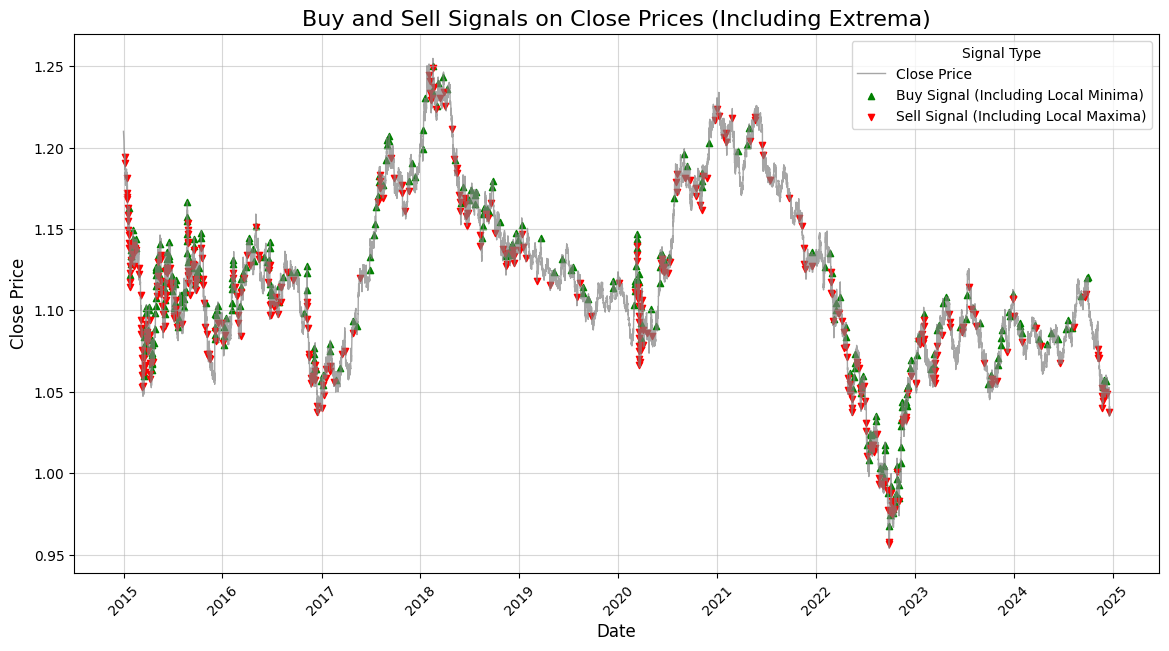

Signal Counts:
Signal
Sell    405
Buy     374
Name: count, dtype: int64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema


def identify_reverse_patterns(df):
    signals = []
    pip_threshold = 0.0030  # 30 pips for EUR/USD

    for i in range(1, len(df)):
        prev_candle = df.iloc[i - 1]
        curr_candle = df.iloc[i]

        # Calculate the trend before the current candle (5-period moving average as trend indicator)
        trend = df['Close'][max(0, i - 11):i].mean()
        is_uptrend = prev_candle['Close'] > trend  # Price above trend for uptrend
        is_downtrend = prev_candle['Close'] < trend  # Price below trend for downtrend

        # Bullish reversal: uptrend + Bullish engulfing pattern
        if (
            is_uptrend  # Confirm uptrend
            and curr_candle['Close'] > curr_candle['Open']  # Current candle is green
#             and curr_candle['Close'] > prev_candle['Open']  # Engulfs previous candle
            and (curr_candle['Close'] - prev_candle['Close']) >= pip_threshold  # 30 pips difference
        ):
            signals.append('Buy')  # Bullish reversal
            continue

        # Bearish reversal: downtrend + Bearish engulfing pattern
        if (
            is_downtrend  # Confirm downtrend
            and curr_candle['Close'] < curr_candle['Open']  # Current candle is red
#             and curr_candle['Close'] < prev_candle['Open']  # Engulfs previous candle
            and (prev_candle['Close'] - curr_candle['Close']) >= pip_threshold  # 30 pips difference
        ):
            signals.append('Sell')  # Bearish reversal
            continue

        # No signal
        signals.append(None)

    # First row cannot have a signal as it has no previous candle
    signals.insert(0, None)
    return signals



df = pd.DataFrame(data)

# Convert dates to matplotlib format for candlestick plotting
# df['Date_Num'] = mdates.date2num(df['Date'])

# Apply reverse pattern logic
df['Signal'] = identify_reverse_patterns(df)


# Identify local maxima and minima
local_maxima_indices = argrelextrema(df['Close'].values, np.greater, order=100)[0]
local_minima_indices = argrelextrema(df['Close'].values, np.less, order=100)[0]

# Count local maxima and minima
total_local_maxima = len(local_maxima_indices)
total_local_minima = len(local_minima_indices)

print(f"Total Local Maxima (Sell Opportunities): {total_local_maxima}")
print(f"Total Local Minima (Buy Opportunities): {total_local_minima}")

# Add local maxima as additional "Sell" signals
# df.loc[df.index[local_maxima_indices], 'Signal'] = 'Sell'

# Add local minima as additional "Buy" signals
# df.loc[df.index[local_minima_indices], 'Signal'] = 'Buy'

# Visualize signals
plt.figure(figsize=(14, 7))

# Plot Close Prices
plt.plot(df['Date'], df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)

# Plot Buy Signals (including local minima)
buy_signals = df[df['Signal'] == 'Buy']
plt.scatter(buy_signals['Date'], buy_signals['Close'], 
            c='green', label='Buy Signal (Including Local Minima)', marker='^', s=20)

# Plot Sell Signals (including local maxima)
sell_signals = df[df['Signal'] == 'Sell']
plt.scatter(sell_signals['Date'], sell_signals['Close'], 
            c='red', label='Sell Signal (Including Local Maxima)', marker='v', s=20)

# Chart Customization
plt.title('Buy and Sell Signals on Close Prices (Including Extrema)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Signal Type')
plt.grid(alpha=0.5)
plt.show()

# Print signal summary
print("Signal Counts:")
print(df['Signal'].value_counts())


In [4]:
df

,time,Open,High,Low,Close,Volume,spread,real_volume,Time,Date,Signal
0,1420048800,1.20997,1.21089,1.20966,1.20999,3237,17,0,2014-12-31 18:00:00,2014-12-31 18:00:00,None
1,1420185600,1.20481,1.20569,1.20479,1.20538,1254,17,0,2015-01-02 08:00:00,2015-01-02 08:00:00,None
2,1420189200,1.20537,1.20574,1.20341,1.20553,3394,17,0,2015-01-02 09:00:00,2015-01-02 09:00:00,Buy
3,1420192800,1.20556,1.20689,1.20442,1.20469,4590,17,0,2015-01-02 10:00:00,2015-01-02 10:00:00,None
4,1420196400,1.20468,1.20599,1.20380,1.20573,4335,17,0,2015-01-02 11:00:00,2015-01-02 11:00:00,Buy
...,...,...,...,...,...,...,...,...,...,...,...
61933,1734688800,1.03816,1.03974,1.03770,1.03913,5104,17,0,2024-12-20 10:00:00,2024-12-20 10:00:00,Buy
61934,1734692400,1.03913,1.03915,1.03749,1.03817,4389,17,0,2024-12-20 11:00:00,2024-12-20 11:00:00,None
61935,1734696000,1.03818,1.03921,1.03803,1.03908,3521,17,0,2024-12-20 12:00:00,2024-12-20 12:00:00,None
61936,1734699600,1.03908,1.03964,1.03785,1.03906,3663,17,0,2024-12-20 13:00:00,2024-12-20 13:00:00,None


Total Local Maxima (Sell Opportunities): 198
Total Local Minima (Buy Opportunities): 184


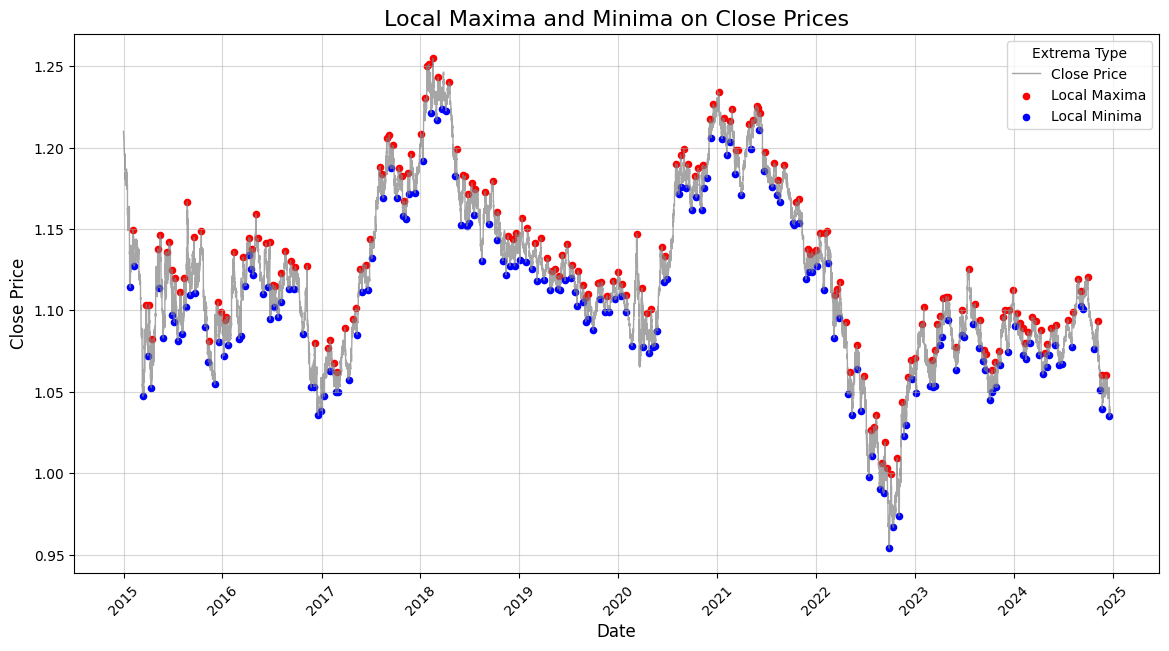

In [7]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains 'Date' and 'Close' columns
# Load your dataframe (replace this with actual data loading)

# Identify local maxima and minima
local_maxima_indices = argrelextrema(df['Close'].values, np.greater, order=100)[0]
local_minima_indices = argrelextrema(df['Close'].values, np.less, order=100)[0]

# Count local maxima and minima
total_local_maxima = len(local_maxima_indices)
total_local_minima = len(local_minima_indices)

print(f"Total Local Maxima (Sell Opportunities): {total_local_maxima}")
print(f"Total Local Minima (Buy Opportunities): {total_local_minima}")


# Plot Close Prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)

# Plot Local Maxima
plt.scatter(df.iloc[local_maxima_indices]['Date'], 
            df.iloc[local_maxima_indices]['Close'], 
            c='red', label='Local Maxima', marker='o', s=20)

# Plot Local Minima
plt.scatter(df.iloc[local_minima_indices]['Date'], 
            df.iloc[local_minima_indices]['Close'], 
            c='blue', label='Local Minima', marker='o', s=20)

# Chart Customization
plt.title('Local Maxima and Minima on Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Extrema Type')
plt.grid(alpha=0.5)
plt.show()


In [48]:
df.drop(columns=['time', 'spread', 'real_volume', 'Cluster_Label'], inplace=True)

In [49]:
df

,Open,High,Low,Close,Volume,Time,Date,Percentage_Change,Signal
1,1.20481,1.20569,1.20479,1.20538,1254,2015-01-02 08:00:00,2015-01-02 08:00:00,-0.380995,Sell
2,1.20537,1.20574,1.20341,1.20553,3394,2015-01-02 09:00:00,2015-01-02 09:00:00,0.012444,None
3,1.20556,1.20689,1.20442,1.20469,4590,2015-01-02 10:00:00,2015-01-02 10:00:00,-0.069679,None
4,1.20468,1.20599,1.20380,1.20573,4335,2015-01-02 11:00:00,2015-01-02 11:00:00,0.086329,Sell
5,1.20573,1.20573,1.20415,1.20501,2731,2015-01-02 12:00:00,2015-01-02 12:00:00,-0.059715,None
...,...,...,...,...,...,...,...,...,...
61933,1.03816,1.03974,1.03770,1.03913,5104,2024-12-20 10:00:00,2024-12-20 10:00:00,0.092470,None
61934,1.03913,1.03915,1.03749,1.03817,4389,2024-12-20 11:00:00,2024-12-20 11:00:00,-0.092385,None
61935,1.03818,1.03921,1.03803,1.03908,3521,2024-12-20 12:00:00,2024-12-20 12:00:00,0.087654,None
61936,1.03908,1.03964,1.03785,1.03906,3663,2024-12-20 13:00:00,2024-12-20 13:00:00,-0.001925,None


In [50]:
# Replace None with 'Hold' in the Signal column
df['Signal'] = df['Signal'].fillna('Hold')

In [53]:
df['Signal'].value_counts()

Hold    61122
Buy       411
Sell      404
Name: Signal, dtype: int64

In [54]:
df.to_csv('Signal_EURUSD.csv')

In [70]:
# Create a copy of the Signal column
modified_signals = df['Signal'].values.copy()

# Initialize variables
previous_signal = None

# Iterate through the signals and modify them
for i in range(len(modified_signals)):
    if modified_signals[i] in ['Buy', 'Sell']:
        if previous_signal and previous_signal != modified_signals[i]:  # Transition detected
            modified_signals[i - 1] = 'Close'  # Insert "Close" before the current signal
        previous_signal = modified_signals[i]

# Assign the modified signals back to the DataFrame
df['Modified_Signal'] = modified_signals

# Print the modified signals for the first 200 rows
# print(df['Modified_Signal'].values[1:500])


In [72]:
print(df['Modified_Signal'].values[1:500])

['Hold' 'Hold' 'Sell' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Sell' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Close' 'Buy' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold

In [71]:
df['Modified_Signal']

1        Sell
2        Hold
3        Hold
4        Sell
5        Hold
         ... 
61933    Hold
61934    Hold
61935    Hold
61936    Hold
61937    Hold
Name: Modified_Signal, Length: 61937, dtype: object